In [1]:
import numpy as np
import matplotlib as mpl
import torch
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.gridspec as gridspec

import os
# import GAN utilities
from evaluation.gen_tests.generation_tests import StyleGEvaluationManager
from utils.utils import mkdir_in_path, load_model_checkp, saveAudioBatch, makesteps

# import mesh adaptation module
import SOM.SOM as som

In [2]:
'''
    The plt arg is so we can plot the mesh on top of other plots
'''
def plotmesh(m,n, p=plt) : 
    p.scatter(m,n, color="black")

    segs1 = np.stack((m,n), axis=2)
    segs2 = segs1.transpose(1,0,2)
    p.gca().add_collection(LineCollection(segs1, colors='black'))
    p.gca().add_collection(LineCollection(segs2, colors='black'))
    p.show()  
    return p

# <span style="color:green"> MESH ADAPTATION using trained GAN </span>

### Set your PARAMs here

In [3]:
#####  PARAMS

#First select a model
dataset="nsynth.oreilly" 


#Now set the model-specific SOM config params
#defaults:
minPitch=None     # none for 4-corner selections with no pitch conditioning
maxPitch=None     # None, minPitch if conditioning and all pitches equal on grid, if conditioning with pitch then typicall xlength-1 
pitchDim=None     # none for 4-corner selections with no pitch conditioning, typically 1 when using conditioned pitch

step=.00005 
iterations=101 
directions=[0,1,2,3,4,5,6,7]   #if pitch conditioning, [0,4] to only interpolate in the timbral dimension
clampedges=True

ylength=21 #number of timbres
xlength=21 #number of number timbres (we use this dim for notes by convention if pitch conditioning)


if dataset=="rhapsody" :
    checkpointdir="output/outname_nsynthsubset_hop128_PGHI_extendedpitch"

    z0=torch.load(checkpointdir+'/generation_tests/outname_nsynthsubset_hop128_PGHI_extendedpitch_s4_i299899/random/2021-06-24 07:32/test_pitch_sweep_17.pt')
    z1=torch.load(checkpointdir+'/generation_tests/outname_nsynthsubset_hop128_PGHI_extendedpitch_s4_i299899/random/2021-06-24 07:32/test_pitch_sweep_17.pt')
    z2=torch.load(checkpointdir+'/generation_tests/outname_nsynthsubset_hop128_PGHI_extendedpitch_s4_i299899/random/2021-06-24 07:32/test_pitch_sweep_21.pt')
    z3=torch.load(checkpointdir+'/generation_tests/outname_nsynthsubset_hop128_PGHI_extendedpitch_s4_i299899/random/2021-06-24 07:32/test_pitch_sweep_21.pt')
    
    # All pitches p2.weights[n,:] (along the same row) will have the same pitch when the kmap class is instantiated. 
    minPitch=56
    maxPitch=76
    pitchDim=1

    step=.00005 #.0000005
    iterations=101 #2001 #10001
    directions=[0,4]   #only interpolate in the timbral dimension
    clampedges=True
    
    ylength=21 #number of timbres
    xlength=21 #number of notes


    
if dataset=="oreilly2" :
    checkpointdir="output/oreilly2"
    z0=torch.load(checkpointdir+'/generation_tests/oreilly2_s4_i149970/random/2021-02-24 02:34/test_pitch_sweep_19.pt')
    z1=torch.load(checkpointdir+'/generation_tests/oreilly2_s4_i149970/random/2021-02-24 02:34/test_pitch_sweep_21.pt')
    z2=torch.load(checkpointdir+'/generation_tests/oreilly2_s4_i149970/random/2021-02-24 02:34/test_pitch_sweep_88.pt')
    z3=torch.load(checkpointdir+'/generation_tests/oreilly2_s4_i149970/random/2021-02-24 02:34/test_pitch_sweep_89.pt')
    
    step=.00000001
    iterations=20001
    directions=[0,1,2,3,4,5,6,7]
    clampedges=True
    
    ylength=21
    xlength=21

if dataset=="trumpinet" :
    checkpointdir="Keepers/nsynthsubsetmodel/output/outname_nsynthsubset_hop128_PGHI"
    
    z0=torch.load(checkpointdir+'/generation_tests/outname_nsynthsubset_hop128_PGHI_s4_i299899/random/2021-04-24 10:13/test_pitch_sweep_45.pt')
    z1=torch.load(checkpointdir+'/generation_tests/outname_nsynthsubset_hop128_PGHI_s4_i299899/random/2021-04-24 10:13/test_pitch_sweep_45.pt')
    z2=torch.load(checkpointdir+'/generation_tests/outname_nsynthsubset_hop128_PGHI_s4_i299899/random/2021-04-24 10:13/test_pitch_sweep_26.pt')
    z3=torch.load(checkpointdir+'/generation_tests/outname_nsynthsubset_hop128_PGHI_s4_i299899/random/2021-04-24 10:13/test_pitch_sweep_26.pt')
    
    # All pitches p2.weights[n,:] (along the same row) will have the same pitch when the kmap class is instantiated.
    #z0=setPitch(z0, eval_manager, "pitch", 64)
    #z1=setPitch(z1, eval_manager, "pitch", 76)
    #z2=setPitch(z2, eval_manager, "pitch", 64)
    #z3=setPitch(z3, eval_manager, "pitch", 76)
    
    #
    minPitch=64 #64
    maxPitch=76 #76
    pitchDim=1

    
    step=.0000005
    iterations=10001
    directions=[0,4]
    clampedges=True
    
    ylength=21
    xlength=13
    

    
if dataset=="firecrowd_1sec" :
    checkpointdir="output/2021.05.04_firecrowd_try2/outname_firecrowd_hop128_PGHI"
    
    z0=torch.load(checkpointdir+'/try2_fourcorners/test_pitch_sweep_4_fire.pt')
    z1=torch.load(checkpointdir+'/try2_fourcorners/test_pitch_sweep_15_fire.pt')
    z2=torch.load(checkpointdir+'/try2_fourcorners/test_pitch_sweep_65_crowd.pt')
    z3=torch.load(checkpointdir+'/try2_fourcorners/test_pitch_sweep_0_crowd.pt') 
    
    step=.00000001
    iterations=20001
    directions=[0,1,2,3,4,5,6,7]
    clampedges=True
    
    ylength=21
    xlength=21
    
if dataset=="nsynth.oreilly" :
    checkpointdir="output/nsynth.oreilly/nsynth_oreilly/outname_nsynthsubset_oreilly_hop128_PGHI"
    
    z0=torch.load(checkpointdir+'/generation_tests/outname_nsynthsubset_oreilly_hop128_PGHI_s4_i299899/2D/2021-05-23 09:07/test_2D4pt_d1.2_d0.16_v.0.pt')
    z1=torch.load(checkpointdir+'/generation_tests/outname_nsynthsubset_oreilly_hop128_PGHI_s4_i299899/2D/2021-05-23 09:07/test_2D4pt_d1.2_d0.18_v.0.pt')
    z2=torch.load(checkpointdir+'/generation_tests/outname_nsynthsubset_oreilly_hop128_PGHI_s4_i299899/2D/2021-05-23 09:07/test_2D4pt_d1.3_d0.14_v.0.pt')
    z3=torch.load(checkpointdir+'/generation_tests/outname_nsynthsubset_oreilly_hop128_PGHI_s4_i299899/2D/2021-05-23 09:07/test_2D4pt_d1.5_d0.16_v.0.pt') 
    
    step=.00001
    iterations=2001
    directions=[0,1,2,3,4,5,6,7]
    clampedges=True
    
    ylength=21
    xlength=21
 

                


In [4]:
#Now load the model
model, config, model_name = load_model_checkp(checkpointdir)
eval_manager = StyleGEvaluationManager(model, n_gen=2)

# OK, create the SOM instance
p2 =som.kmap(ylength,xlength,z0.cpu(),z1.cpu(),z2.cpu(),z3.cpu(), vizdims=eval_manager.latent_noise_dim) #( ylength (num rows), (xlength (num cols))
p2.weights.shape

latentVectorDim (128) = noiseVectorDim (128) + categoryVectorDim_G (0)
PGAN: Building Generator

Size scale 0: [8, 8]

Checkpoint found at scale 4, iter 299899
PGAN: Building Generator

Size scale 0: (17, 8)

Average network found !
weights.shape is (21, 21, 128)
xspacing is 0.07362536259629929. and yspacing is 0.555359939886819
weights2D.shape is (21, 21, 2)


(21, 21, 128)

In [5]:
# here we set the one-hot part of the latent vector to be the values for requested pitches
# Set a single pitch for given column, incrementing across columns
# Have to do this *after* creating the kmap because that's where the grid of latents is generated. 
if minPitch != None :
    if pitchDim == 0 :
        numPitches=ylength 
    if pitchDim == 1 :
        numPitches=xlength
    if (maxPitch-minPitch) != 0  : #if not asking for constant pitch
        assert abs(maxPitch-minPitch)+1 == numPitches, f"pitch range is [{minPitch},{maxPitch}], but dimension {pitchDim} is of length {numPitches}"

    for i in range(ylength) :
        for j in range(xlength) :
            if pitchDim == 0 : # increment pitch across rows
                p2.weights[i, j] = som.setPitch(p2.weights[i, j], eval_manager, "pitch", i+minPitch)
            elif pitchDim == 1 : # increment pitch across columns
                p2.weights[i, j] = som.setPitch(p2.weights[i, j], eval_manager, "pitch", j+minPitch)
            else : # all sounds at same pitch
                p2.weights[i, j] = som.setPitch(p2.weights[i, j], eval_manager, "pitch", minPitch)


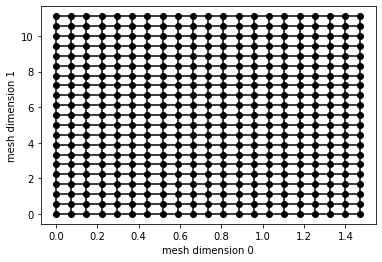

In [6]:
plt.xlabel("mesh dimension 0")
plt.ylabel("mesh dimension 1")
plotmesh(p2.weights2D[:,:,0], p2.weights2D[:,:,1])

origweights2D=p2.weights2D

In [7]:
batched_latents=torch.Tensor(p2.weights.reshape(ylength*xlength,p2.weights.shape[2]))
gen_batch = model.test(batched_latents, toCPU=True, getAvG=True)

In [8]:
gen_batch.shape

torch.Size([441, 1, 257, 128])

In [9]:
gen_batch=gen_batch.numpy().reshape(ylength,xlength,257,128)

In [10]:
gen_batch.shape

(21, 21, 257, 128)

In [11]:
# PRE ADAPTATION  3D

# Let's see what the matrix of average distances between neighbors looks like before SOM linearization
spectdiff=p2.getDifferences(gen_batch, directions=directions)
pre_avgs=np.average(np.abs(spectdiff), axis=2)

#from mpl_toolkits.mplot3d import Axes3D
#import matplotlib.pyplot as plt
#import numpy as np
print(f'pre_avgs.shape={pre_avgs.shape}')
xidxmax, yidxmax=pre_avgs.shape
print(f"xidxmax={xidxmax}, yidxmax={yidxmax}")

X = np.arange(0, xidxmax)
Y = np.arange(0, yidxmax)

pre_avgs.shape=(21, 21)
xidxmax=21, yidxmax=21


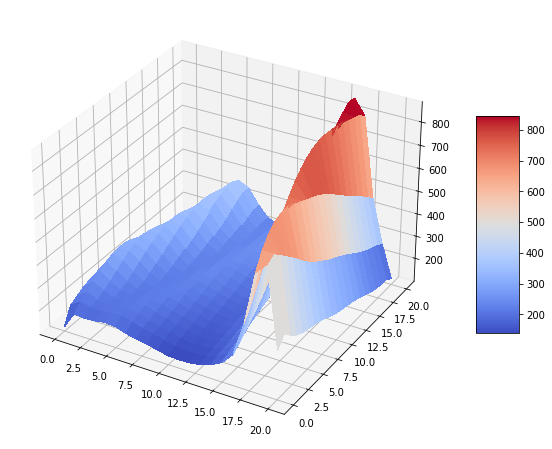

In [12]:
X, Y = np.meshgrid(X, Y, indexing='ij')

fig = plt.figure()
ax = fig.gca(projection='3d')
#ax.view_init(elev=15., azim=-360)
surf = ax.plot_surface(X, Y, pre_avgs, rstride=1, cstride=1, cmap='coolwarm', linewidth=0, antialiased=False)

fig.set_size_inches(12, 8)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

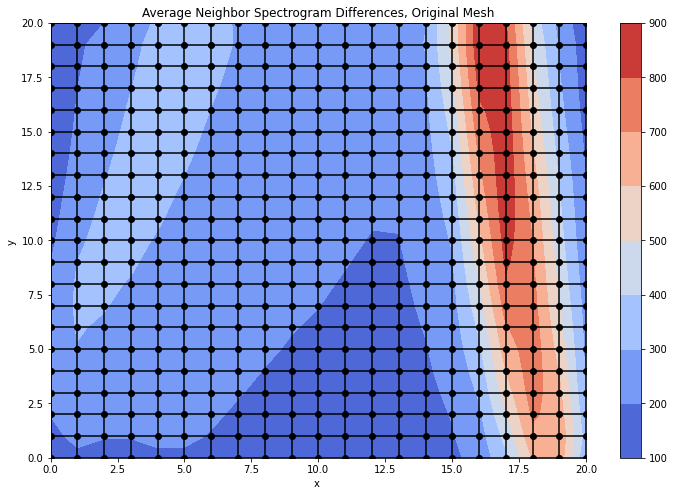

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [13]:
# PRE ADAPTATION CONTOUR

cmap = 'coolwarm' #mpl.cm.cool
xidxmax, yidxmax=pre_avgs.shape
vmax= np.amax(pre_avgs) #80#900
vmin=0

def map(x, maxv) :
    a=np.min(x)
    b=np.max(x)
    return maxv*(x-a)/(b-a)

# get out mesh of node weights
X = np.arange(0, xidxmax)
Y = np.arange(0, yidxmax)
X, Y = np.meshgrid(map(X, xidxmax-1), map(Y, yidxmax-1), indexing='ij')


fig,ax=plt.subplots(1,1)
fig.set_size_inches(12, 8)
cp = ax.contourf(X, Y, pre_avgs, cmap=cmap)  #original mesh to plot guassian

fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Average Neighbor Spectrogram Differences, Original Mesh')
ax.set_xlabel('x ')
ax.set_ylabel('y ')


##########
#Put the mesh on top of the values
plotmesh(X,Y, plt)
#plt.show()

finished iteration 0
0: changesum is 65340.61814137678


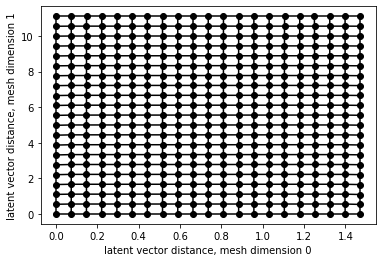

finished iteration 100
100: changesum is 9620.477561286969


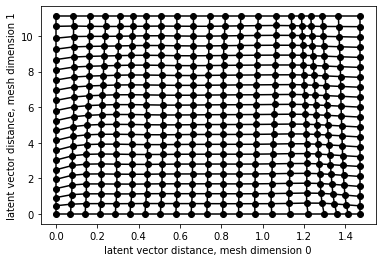

finished iteration 200
200: changesum is 6754.087922087791


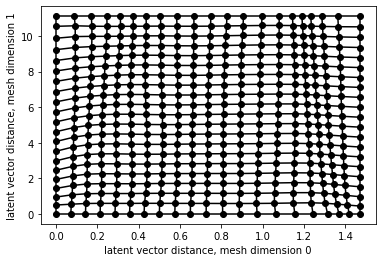

finished iteration 300
300: changesum is 5526.846796677992


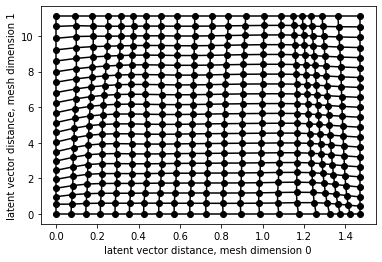

In [14]:
# Now do the SOM Linearization

hgram=[]
hgramInterval=100

#tempiterations=301

for i in range (iterations) : #(iterations) :
    # get the new spectrograms at the latent locations on the mesh
   
    # Stack up weights into a single list for batch processing bythe GAN
    batched_latents=torch.Tensor(p2.weights.reshape(ylength*xlength,p2.weights.shape[2]))
    # Compute the values of the functions at each node location 
    #G = two_Guassians(mX,mY, mu1, Sigma1, mu2, Sigma2)
    gen_batch = model.test(batched_latents, toCPU=True, getAvG=True)
    gen_batch_npmatrix=gen_batch.numpy().reshape(ylength,xlength,257,128)
    
    changesum, diffm=p2.weightUpdate(gen_batch_npmatrix, step=step, clampedges=clampedges, directions=directions)

    # occaissionally save the histogram of differences between nodes
    if i%hgramInterval == 0 :
        #print(f"save histogrqam at step {i}")
        hgram.append(np.histogram(diffm[:,:], 12,(0,.5)))
        print(f"finished iteration {i}")
        
        print(f"{i}: changesum is {changesum}")
        
        plt.xlabel("latent vector distance, mesh dimension 0")
        plt.ylabel("latent vector distance, mesh dimension 1")
        plotmesh( p2.weights2D[:,:,0], p2.weights2D[:,:,1], plt)
        plt.pause(0.05)
    


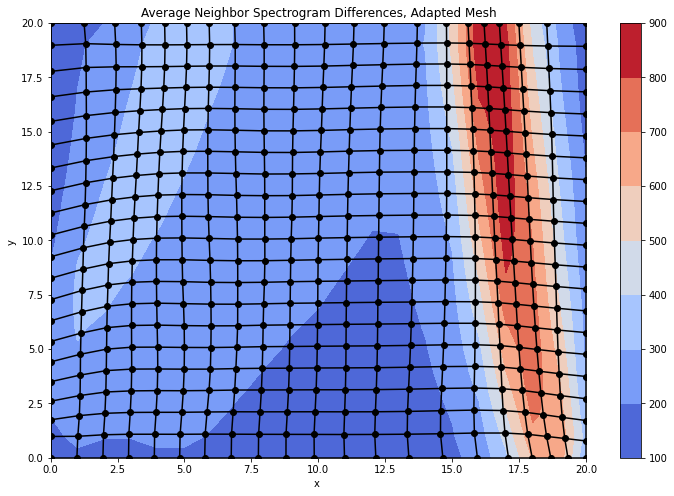

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [15]:

#POST ADAPTATION MESH on original contour

cmap = 'coolwarm' #mpl.cm.cool

# get out mesh of node weights
xidxmax, yidxmax=pre_avgs.shape
vmax= np.amax(pre_avgs) #80#900
vmin=0

#norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)


def map(x, maxv) :
    a=np.min(x)
    b=np.max(x)
    return maxv*(x-a)/(b-a)

# get out mesh of node weights
X = np.arange(0, xidxmax)
Y = np.arange(0, yidxmax)
X, Y = np.meshgrid(map(X, xidxmax-1), map(Y, yidxmax-1), indexing='ij')


fig,ax=plt.subplots(1,1)
fig.set_size_inches(12, 8)
cp = ax.contourf(X, Y, pre_avgs, cmap=cmap, vmax=vmax)  #original mesh to plot guassian

fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title("Average Neighbor Spectrogram Differences, Adapted Mesh")
ax.set_xlabel('x ')
ax.set_ylabel('y ')


    
##########
#Put the mesh on top of the values
#plotmesh(X,Y, plt)
# get out mesh of node weights
#m,n = p2.locationMesh()
#p=np.min(m)
#plotmesh(map(m), n, plt)
plotmesh(map(p2.weights2D[:,:,0], xidxmax-1), map(p2.weights2D[:,:,1], yidxmax-1), plt)

In [16]:
gen_batch[0,0,:,:].shape

torch.Size([257, 128])

In [17]:
np.min(pre_avgs)

111.23843193054199

In [18]:
np.amin(gen_batch.numpy()[:,0,:,:])

-57.306675

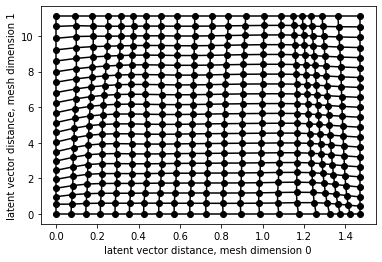

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [19]:
plt.xlabel("latent vector distance, mesh dimension 0")
plt.ylabel("latent vector distance, mesh dimension 1")
#plt.gca().invert_yaxis()
plotmesh( p2.weights2D[:,:,0], p2.weights2D[:,:,1], plt)

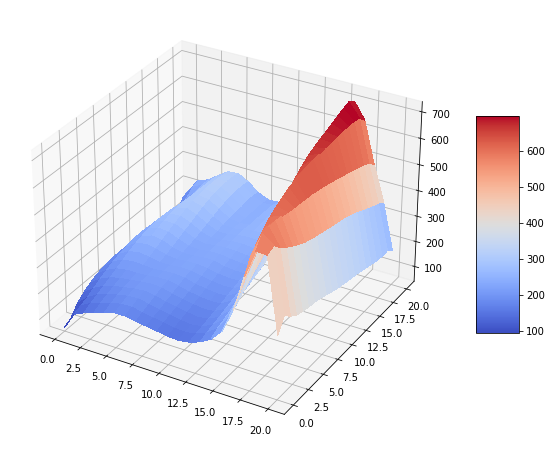

In [20]:
spectdiff=p2.getDifferences(gen_batch_npmatrix, directions=directions)
avgs=np.average(np.abs(spectdiff), axis=2)

#from mpl_toolkits.mplot3d import Axes3D
#import matplotlib.pyplot as plt
#import numpy as np

# get out mesh of node weights
xidxmax, yidxmax=pre_avgs.shape
vmax= np.amax(pre_avgs) #80#900
vmin=0

#norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)


def map(x, maxv) :
    a=np.min(x)
    b=np.max(x)
    return maxv*(x-a)/(b-a)

# get out mesh of node weights
X = np.arange(0, xidxmax)
Y = np.arange(0, yidxmax)
X, Y = np.meshgrid(map(X, xidxmax-1), map(Y, yidxmax-1), indexing='ij')

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, avgs, rstride=1, cstride=1, cmap='coolwarm', linewidth=0, antialiased=False)

fig.set_size_inches(12, 8)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


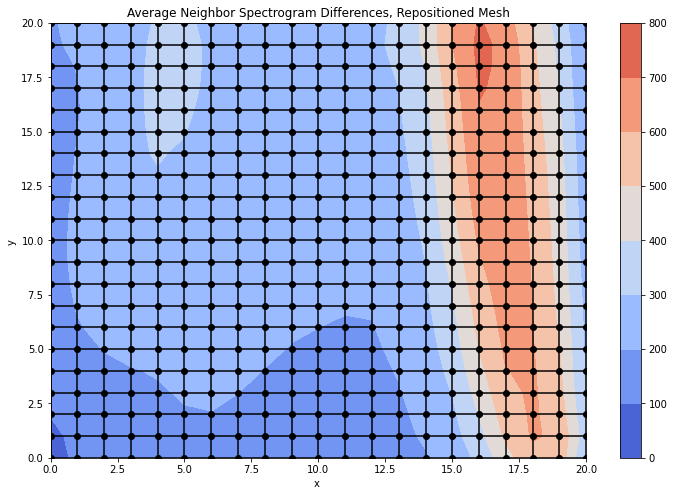

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [21]:
cmap='coolwarm'

xidxmax, yidxmax=avgs.shape
vmax= np.amax(pre_avgs) #80#900
vmin=0

def map(x, maxv) :
    a=np.min(x)
    b=np.max(x)
    return maxv*(x-a)/(b-a)

# get out mesh of node weights
X = np.arange(0, xidxmax)
Y = np.arange(0, yidxmax)
X, Y = np.meshgrid(map(X, xidxmax-1), map(Y, yidxmax-1), indexing='ij')


fig,ax=plt.subplots(1,1)
fig.set_size_inches(12, 8)
cp = ax.contourf(X, Y, avgs, cmap=cmap, vmax=vmax)  #original mesh to plot guassian

fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Average Neighbor Spectrogram Differences, Repositioned Mesh')
ax.set_xlabel('x ')
ax.set_ylabel('y ')


##########
#Put the mesh on top of the values
plotmesh(X,Y, plt)
#plt.show()

In [22]:
p2.weights[5,10,:]

array([-0.58224104, -0.18082101,  0.09515987,  0.43225812, -0.11865317,
       -0.26110456,  0.05145329, -0.03064779,  1.22235761, -0.94642794,
        0.12659589, -0.31150167, -1.01651217, -0.73107155,  0.05016667,
       -0.32009307, -0.58970093,  0.18238003, -1.29645515,  2.05282508,
        0.38262461, -0.2636014 ,  0.25080014, -0.48789403, -0.55633684,
        0.41632037, -0.85318718, -0.93997602, -0.24286178, -1.40852831,
       -0.11735213, -1.6935213 , -0.04350093, -0.74123064,  0.49843232,
       -0.13616339,  1.18537548, -1.03412534,  1.63496166, -0.59651446,
        1.33910557,  0.69679036, -1.05626144, -0.1733814 ,  0.61188461,
        0.62345671, -0.77428932,  0.23980931,  1.4418523 , -0.28162101,
        0.66161406,  0.24254375, -0.46997685, -0.59977022, -0.13607383,
       -0.12338265,  0.6214691 ,  0.40993332, -0.28420887,  0.88202701,
        0.40422274,  0.44713801, -1.30158602,  1.48627713, -0.05302307,
        0.58512426,  0.65006508, -0.35970317,  0.58740842,  1.18

Text(0.5, 0, 'number of nodes in bin')

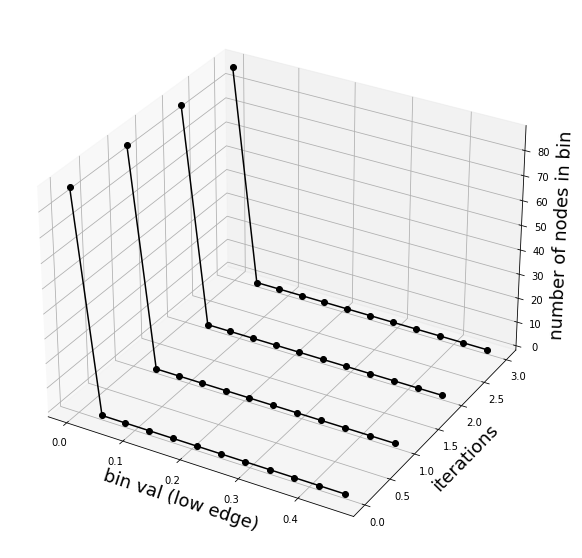

In [23]:
'''
    Plot the histograms of value differences between nodes over times
'''
#import matplotlib.pylab as pl
#from matplotlib import colors
#from mpl_toolkits.mplot3d import Axes3D
#import numpy as np

nbins=len(hgram[0][0])
nsteps=len(hgram)
y=np.zeros((nsteps, nbins))
z=np.zeros((nsteps, nbins))
x   = hgram[0][1][:nbins]  #bin center
for snum in range(0, nsteps) :
    y[snum]  = np.ones(nbins)*snum
    z[snum]   = hgram[snum][0]


fig1=plt.figure(figsize=(10,10))
#ax11=fig1.add_subplot(211,projection='3d')
ax11=fig1.add_subplot(111,projection='3d')

#ax = pl.subplot(projection='3d')
for snum in range(0, nsteps) :
    #ax11.plot(x, y[snum], z[snum], marker='o', color=colors.hsv_to_rgb([np.random.uniform(0, 1),.7,1]))
    ax11.plot(x, y[snum], z[snum], marker='o', color='#000000')


ax11.set_xlabel('bin val (low edge)', fontsize=18)
ax11.set_ylabel('iterations', fontsize=18)
ax11.set_zlabel('number of nodes in bin', fontsize=18) 

# SAVE the grid

In [24]:
# Here we save the who kitnkaboodle to a .pt file 
# To convert the pt file and write out the wave files and paramManager files for training an TNN afterwards, see
# spectset2paramsound.py:
# python spectset2paramsound.py --gen_batch output/outname_.pt --d0 21 --d1 21 --pm True -d modeldir

if False :   #Change to True when you are ready to save your adapted grid
    outpath=checkpointDir + "/SOMoutput"
    #outpath=checkpointDir + "/SOMgrid"
    if not os.path.exists(outpath):
        os.makedirs(outpath)

    torch.save((gen_batch,batched_latents), outpath+"/2021.06.24_rhapsody.pt")
    outpath

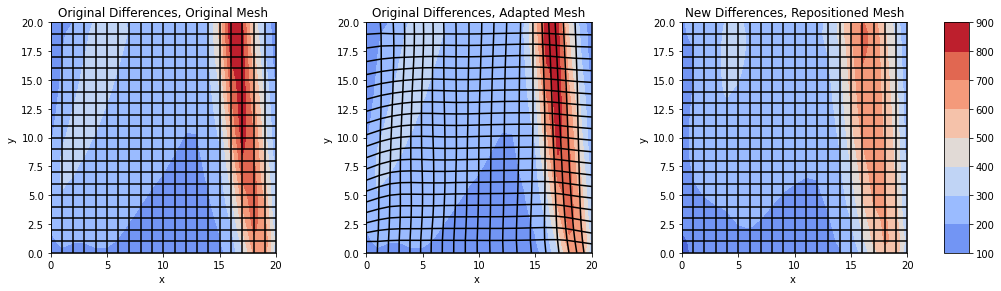

In [25]:
# This is just for generating a nice image 
cmap='coolwarm'

xidxmax, yidxmax=avgs.shape
vmax= np.amax(pre_avgs) #80#900
vmin=0

def map(x, maxv) :
    a=np.min(x)
    b=np.max(x)
    return maxv*(x-a)/(b-a)

# get out mesh of node weights
X = np.arange(0, xidxmax)
Y = np.arange(0, yidxmax)
X, Y = np.meshgrid(map(X, xidxmax-1), map(Y, yidxmax-1), indexing='ij')

fig = plt.figure()
fig.set_size_inches(17, 4)

ax = fig.add_subplot(131)
mesh = ax.contourf(X, Y, pre_avgs, cmap=cmap)  
mesh.set_clim(vmin,vmax)
ax.set_title('Original Differences, Original Mesh')
ax.set_xlabel('x ')
ax.set_ylabel('y ')

segs1 = np.stack((X,Y), axis=2)
segs2 = segs1.transpose(1,0,2)
plt.gca().add_collection(LineCollection(segs1, colors='black'))
plt.gca().add_collection(LineCollection(segs2, colors='black'))
#plt.scatter(X,Y, color="black")



# (b)
ax1 = fig.add_subplot(132)
mesh1 = ax1.contourf(X, Y, pre_avgs, cmap=cmap)
mesh1.set_clim(vmin,vmax)
ax1.set_title('Original Differences, Adapted Mesh')
ax1.set_xlabel('x ')
ax1.set_ylabel('y ')

#plotmesh(map(p2.weights2D[:,:,1]), map(p2.weights2D[:,:,0]), plt)
X_= map(p2.weights2D[:,:,0], xidxmax-1)
Y_ = map(p2.weights2D[:,:,1],  yidxmax-1)
segs1 = np.stack((X_,Y_), axis=2)
segs2 = segs1.transpose(1,0,2)
plt.gca().add_collection(LineCollection(segs1, colors='black'))
plt.gca().add_collection(LineCollection(segs2, colors='black'))
#plt.scatter(X_,Y_, color="black")


# (c)

ax2 = fig.add_subplot(133)
mesh2 = ax2.contourf(X, Y, avgs, cmap=cmap)
mesh2.set_clim(vmin,vmax)
ax2.set_title('New Differences, Repositioned Mesh')
ax2.set_xlabel('x ')
ax2.set_ylabel('y ')

segs1 = np.stack((X,Y), axis=2)
segs2 = segs1.transpose(1,0,2)
plt.gca().add_collection(LineCollection(segs1, colors='black'))
plt.gca().add_collection(LineCollection(segs2, colors='black'))
#plt.scatter(X,Y, color="black")



fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.4, hspace=0.1)
cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(mesh, cax=cb_ax)

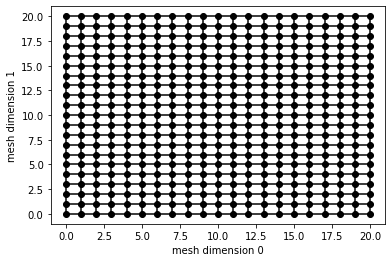

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [26]:
plt.xlabel("mesh dimension 0")
plt.ylabel("mesh dimension 1")
#plt.gca().invert_yaxis()
plotmesh(X, Y, plt)